In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

/tmp/ipykernel_234622/254083166.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-01 08:14:07.996209: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-01 08:14:08.034577: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 08:14

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)


CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [3]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=pd.concat([data_water, data_ice, data_mixed])
#data_all=pd.concat([data_ice])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

df=data_all.copy()
#data_all=hf.add_MSI_noise(data_all,channel_labels)

##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels_one=['Clear_B12']
y_labels_all=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']

In [4]:


X_truth=df_truth[X_labels]


#df=hf.normalise_input_df(data_all,X_labels)
#df=hf.add_noise(df,X_labels,sigma=0.001)


X=df[X_labels]
y_all=df[y_labels_all]
y_one=df[y_labels_one]

X_train, X_test, y_train_all, y_test_all=train_test_split(X,y_all,test_size=0.05)

indexes_training_data=y_train_all.index
indexes_test_data=y_test_all.index

y_train_one=y_one.iloc[indexes_training_data]
y_test_one=y_one.iloc[indexes_test_data]



In [5]:
import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X_train['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]


Best model out of total max epochs found at epoch 260


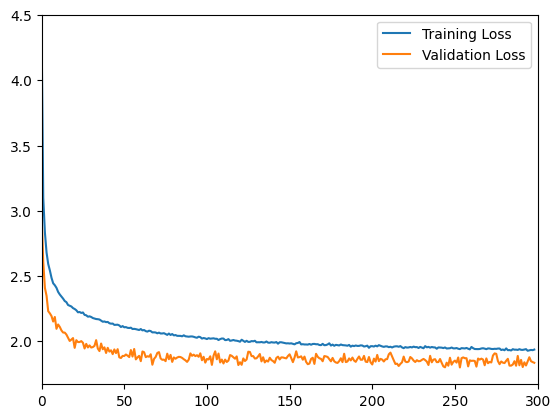

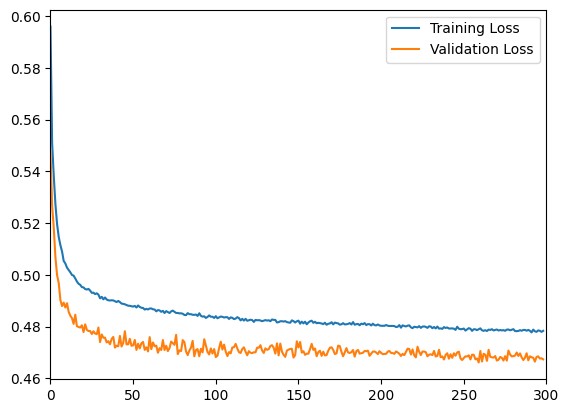

In [6]:
quantiles=np.array([0.1,0.5,0.9])
batch_size=500
save=False

nepochs=300
model_all=QuantileNetwork(quantiles=quantiles)
model_one=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
n_nodes_all=128
sequence_all=lambda: nn.Sequential(
    nn.Linear(len(X_labels),n_nodes_all),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.ReLU(),
    nn.Linear(n_nodes_all, len(quantiles)*len(y_labels_all)) #Output dimesion is number of quantiles times number of target variables
)
n_nodes_one=64
sequence_one=lambda: nn.Sequential(
    nn.Linear(len(X_labels),n_nodes_one),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(n_nodes_one,n_nodes_one),
    nn.ReLU(),
    nn.Linear(n_nodes_one, len(quantiles)*len(y_labels_one)) #Output dimesion is number of quantiles times number of target variables
)

model_all.fit(X_train.to_numpy(),y_train_all.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence_all(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)

if save:
    hf.save_model_and_test_data(filepath='pytorch_models/test_estimate_1_v_all_channels/all',model=model_all,X_test=X_test,y_test=y_test_all)
    print("Model all saved...")

model_one.fit(X_train.to_numpy(),y_train_one.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence_one(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)

if save:
    hf.save_model_and_test_data(filepath='pytorch_models/test_estimate_1_v_all_channels/one',model=model_one,X_test=X_test,y_test=y_test_one)
    print("Model one saved...")


## Load trained models and Visualise

In [4]:
#Load models
model_all,X_test,y_test_all=hf.load_model_and_test_data('pytorch_models/test_estimate_1_v_all_channels/all')
model_one,X_test,y_test_one=hf.load_model_and_test_data('pytorch_models/test_estimate_1_v_all_channels/one')


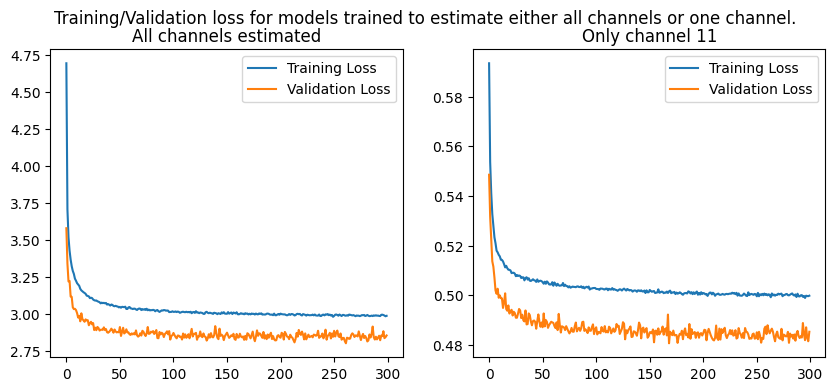

In [6]:
plt.rcParams["figure.figsize"] = [10, 4]
fig, ax =plt.subplots(nrows=1,ncols=2)
fig.suptitle("Training/Validation loss for models trained to estimate either all channels or one channel.")

ax[0].plot(model_all.train_loss.data.cpu().numpy())
ax[0].plot(model_all.val_loss.data.cpu().numpy())
ax[0].set_title("All channels estimated")
ax[0].legend(['Training Loss','Validation Loss'])

ax[1].plot(model_one.train_loss.data.cpu().numpy())
ax[1].plot(model_one.val_loss.data.cpu().numpy())
ax[1].set_title("Only channel 11")
ax[1].legend(['Training Loss','Validation Loss'])

In [31]:
cot_limit=True
cot_limit_val=3.6
if cot_limit:
    df_test=df.iloc[X_test.index]
    X_test=df_test[df_test['COT']<cot_limit_val][X_labels]
    indexes=X_test.index
    y_test_all=df.iloc[indexes][y_labels_all]
    y_test_one=df.iloc[indexes][y_labels_one]

In [32]:
#Make predictions
y_preds_all=model_all.predict(X_test.to_numpy())
y_preds_all_11=y_preds_all[:,10,:]
y_preds_one=model_one.predict(X_test.to_numpy())
y_preds_one=y_preds_one[:,0,:]



In [33]:
y_test_all

,Clear_B02,Clear_B03,Clear_B04,Clear_B05,Clear_B06,Clear_B07,Clear_B08,Clear_B09,Clear_B10,Clear_B11,Clear_B12,Clear_B13
26618,0.21409,0.20097,0.29656,0.18379,0.39489,0.98655,0.94873,0.99774,0.41528,0.00080,0.94454,0.74289
32376,0.35338,0.35015,0.51515,0.45897,0.72783,0.93347,0.80945,0.97763,0.04710,0.00047,0.90569,0.75332
47907,0.22799,0.23003,0.31654,0.21861,0.43636,0.97727,0.91124,0.99586,0.22284,0.00037,0.90179,0.64382
15994,0.32375,0.37111,0.51324,0.69892,0.78193,0.85365,0.91209,1.00036,0.68414,0.03966,0.96377,0.94883
22377,0.24339,0.23594,0.38588,0.24445,0.53762,0.99049,0.98111,0.99700,0.71957,0.05655,0.94208,0.85200
...,...,...,...,...,...,...,...,...,...,...,...,...
12804,0.29588,0.27810,0.31744,0.25242,0.39366,0.95837,0.83269,0.99280,0.05347,0.00029,0.93053,0.78386
49232,0.29299,0.26461,0.30544,0.23412,0.37183,0.93034,0.77541,0.97962,0.01916,0.00038,0.89795,0.68180
16931,0.21732,0.24600,0.49444,0.20089,0.68249,0.97673,0.89271,0.99802,0.15278,0.00041,0.94282,0.85942
39569,0.29491,0.32695,0.49083,0.76328,0.84339,0.92679,0.78162,0.97653,0.02359,0.00046,0.89250,0.70641


In [34]:
## Calculate residuals
y_all=y_test_all.to_numpy()[:,10]
res_all=y_all-y_preds_all_11[:,1]

y_one=y_test_one.to_numpy()[:,0]
res_one=y_one-y_preds_one[:,1]

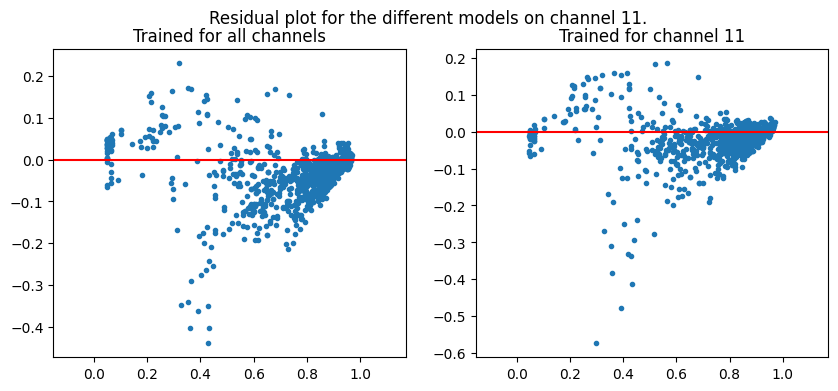

In [35]:
#Plot residuals
fig, ax =plt.subplots(nrows=1,ncols=2)
fig.suptitle("Residual plot for the different models on channel 11.")

ax[0].plot(y_all,res_all,'.')
ax[0].set_title("Trained for all channels")
ax[0].hlines(0,xmin=-1,xmax=10,colors='r')
ax[0].set_xlim((np.min(y_all)-0.2,np.max(y_all)+0.2))

ax[1].plot(y_one,res_one,'.')
ax[1].set_title("Trained for channel 11")
ax[1].hlines(0,xmin=-1,xmax=10,colors='r')
ax[1].set_xlim((np.min(y_one)-0.2,np.max(y_one)+0.2))

plt.show()


In [36]:
r2_all=r2_score(y_all,y_preds_all_11[:,1])
r2_one=r2_score(y_one,y_preds_one[:,1])
mse_all=mean_squared_error(y_all,y_preds_all_11[:,1])
mse_one=mean_squared_error(y_one,y_preds_one[:,1])

print("R2 score channel 11, model trained for all channels: "+str(r2_all))
print("R2 score channel 11, model trained for channel 11: "+str(r2_one))
print(" ")
print("MSE score channel 11, model trained for all channels: "+str(mse_all))
print("MSE score channel 11, model trained for channel 11: "+str(mse_one))


R2 score channel 11, model trained for all channels: 0.9150796175649465
R2 score channel 11, model trained for channel 11: 0.9405781055357602
 
MSE score channel 11, model trained for all channels: 0.0033990084735199145
MSE score channel 11, model trained for channel 11: 0.0023784104240348494


In [22]:
samples=len(X_test)
#samples=100

/tmp/ipykernel_228782/13741708.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax[0].errorbar(x=y_all_samps_sort
/tmp/ipykernel_228782/13741708.py:34: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax[1].errorbar(x=y_one_samps_sort


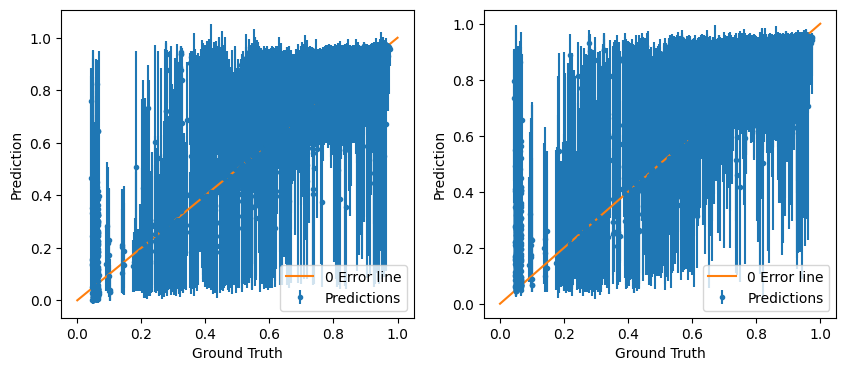

In [23]:

#Get ground truth y, all model
y_all_samps=y_all[0:samples]
sort_ind=np.argsort(y_all_samps)
y_all_samps_sort=y_all_samps[sort_ind]

#Get y predictions, all model
y_pred_all_samps=y_preds_all_11[0:samples,:]
y_pred_all_samps_sort=y_pred_all_samps[sort_ind,:]

#Get ground truth y, one model
y_one_samps=y_one[0:samples]
sort_ind_one=np.argsort(y_one_samps)
y_one_samps_sort=y_one_samps[sort_ind_one]

#Get y predictions, one model
y_pred_one_samps=y_preds_one[0:samples,:]
y_pred_one_samps_sort=y_pred_one_samps[sort_ind,:]


#plt.plot(y_plot_sort,'.')
fig,ax=plt.subplots(nrows=1,ncols=2)
ax[0].errorbar(x=y_all_samps_sort
             ,y=y_pred_all_samps_sort[:,1],
             yerr=[np.abs(y_pred_all_samps_sort[:,1]-y_pred_all_samps_sort[:,0]),
                   np.abs(y_pred_all_samps_sort[:,1]-y_pred_all_samps_sort[:,2])],
                    marker='.',fmt='.')
#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
ax[0].plot(line,line)
ax[0].legend(['0 Error line','Predictions'])
ax[0].set_xlabel("Ground Truth")
ax[0].set_ylabel("Prediction")

ax[1].errorbar(x=y_one_samps_sort
             ,y=y_pred_one_samps_sort[:,1],
             yerr=[np.abs(y_pred_one_samps_sort[:,1]-y_pred_one_samps_sort[:,0]),
                   np.abs(y_pred_one_samps_sort[:,1]-y_pred_one_samps_sort[:,2])],
                    marker='.',fmt='.')
ax[1].plot(line,line)
ax[1].legend(['0 Error line','Predictions'])
ax[1].set_xlabel("Ground Truth")
ax[1].set_ylabel("Prediction")

plt.show()

/tmp/ipykernel_228782/2070949516.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax[0].errorbar(x=np.linspace(0,samples,samples)
/tmp/ipykernel_228782/2070949516.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax[1].errorbar(x=np.linspace(0,samples,samples)


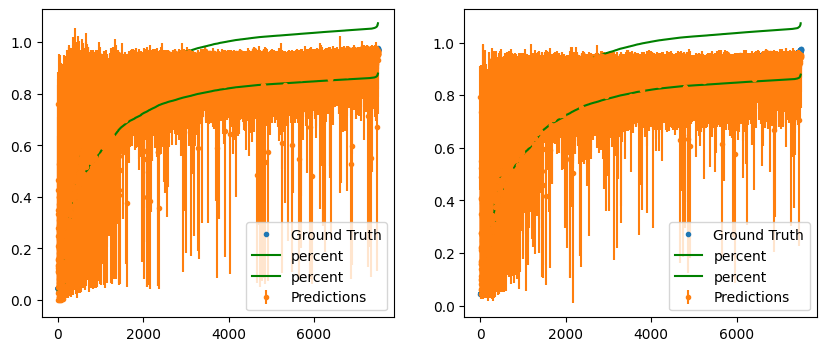

In [24]:

fig,ax =plt.subplots(nrows=1,ncols=2)

ax[0].plot(y_all_samps_sort,'.',label='Ground Truth')
ax[0].errorbar(x=np.linspace(0,samples,samples)
             ,y=y_pred_all_samps_sort[:,1],
             yerr=[np.abs(y_pred_all_samps_sort[:,1]-y_pred_all_samps_sort[:,0]),
                   np.abs(y_pred_all_samps_sort[:,1]-y_pred_all_samps_sort[:,2])],
                    marker='.',fmt='.',label='Predictions')

percent=0.1
ax[0].plot(y_all_samps_sort-y_all_samps_sort*percent,'g',label='percent')
ax[0].plot(y_all_samps_sort+y_all_samps_sort*percent,'g',label='percent')
#ax[0].legend(['Ground truth',str(percent*100)+' percent from ground','.','Predictions'])
ax[0].legend()

ax[1].plot(y_one_samps_sort,'.',label='Ground Truth')
ax[1].errorbar(x=np.linspace(0,samples,samples)
             ,y=y_pred_one_samps_sort[:,1],
             yerr=[np.abs(y_pred_one_samps_sort[:,1]-y_pred_one_samps_sort[:,0]),
                   np.abs(y_pred_one_samps_sort[:,1]-y_pred_one_samps_sort[:,2])],
                    marker='.',fmt='.',label='Predictions')

ax[1].plot(y_one_samps_sort-y_all_samps_sort*percent,'g',label='percent')
ax[1].plot(y_one_samps_sort+y_all_samps_sort*percent,'g',label='percent')
ax[1].legend()
#plt.plot(cloudy_sort,'.')
#plt.legend(['Ground truth','Cloudy signal','prediction'])
plt.show()

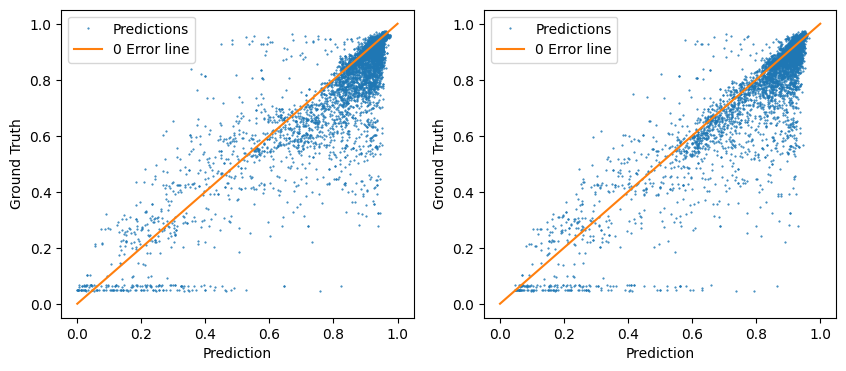

In [25]:
#plt.plot(y_plot_sort,'.')
fig,ax=plt.subplots(nrows=1,ncols=2)
ax[0].plot(y_pred_all_samps_sort[:,1],y_all_samps_sort,'.',markersize=1)
#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
ax[0].plot(line,line)
ax[0].legend(['Predictions','0 Error line'])
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Ground Truth")

ax[1].plot(y_pred_one_samps_sort[:,1],y_one_samps_sort,'.',markersize=1)
ax[1].plot(line,line)
ax[1].legend(['Predictions','0 Error line'])
ax[1].set_xlabel("Prediction")
ax[1].set_ylabel("Ground Truth")

plt.show()

/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Ground Truth')

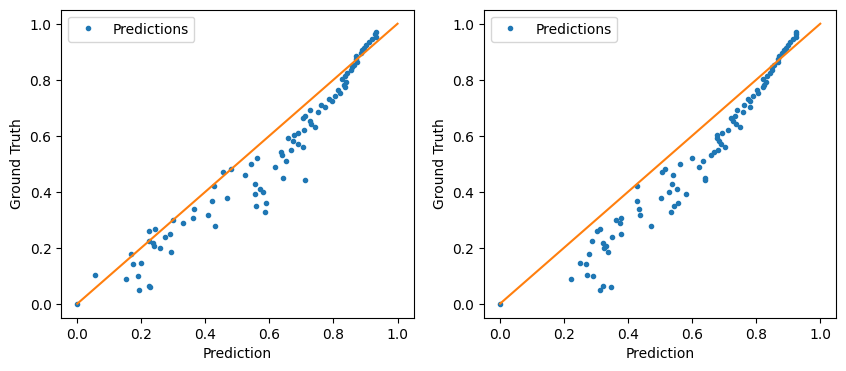

In [26]:
bins=np.linspace(0,1,100)
freq_all_true=np.zeros(len(bins))
freq_all_pred=np.zeros(len(bins))
for i,edge in enumerate(bins):
    if i!=0:
        indices=(y_all_samps_sort>bins[i-1])&(y_all_samps_sort<=edge)
        mean_bin_true=np.mean(y_all_samps_sort[indices])
        mean_bin_pred=np.mean(y_pred_all_samps_sort[indices])
        
        freq_all_true[i]=mean_bin_true
        freq_all_pred[i]=mean_bin_pred



freq_one_true=np.zeros(len(bins))
freq_one_pred=np.zeros(len(bins))
for i,edge in enumerate(bins):
    if i!=0:
        indices=(y_one_samps_sort>bins[i-1])&(y_one_samps_sort<=edge)
        mean_bin_true=np.mean(y_one_samps_sort[indices])
        mean_bin_pred=np.mean(y_pred_one_samps_sort[indices])
        
        freq_one_true[i]=mean_bin_true
        freq_one_pred[i]=mean_bin_pred


#plt.plot(y_plot_sort,'.')
fig,ax=plt.subplots(nrows=1,ncols=2)
ax[0].plot(freq_all_pred,freq_all_true,'.')
#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
ax[0].plot(line,line)
ax[0].legend(['Predictions'])
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Ground Truth")

ax[1].plot(freq_one_pred,freq_one_true,'.')
ax[1].plot(line,line)
ax[1].legend(['Predictions'])
ax[1].set_xlabel("Prediction")
ax[1].set_ylabel("Ground Truth")

In [27]:
len(y_pred_all_samps_sort)

7500

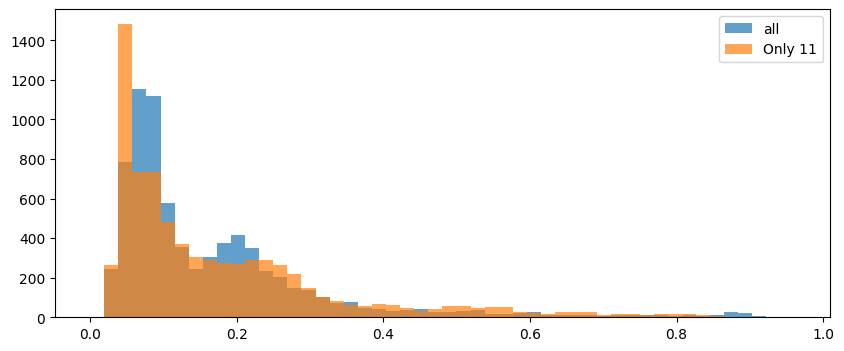

In [28]:
uncertainty_all=y_pred_all_samps_sort[:,2]-y_pred_all_samps_sort[:,0]
uncertainty_one=y_pred_one_samps_sort[:,2]-y_pred_one_samps_sort[:,0]

plt.hist(uncertainty_all,bins=50,range=[0,np.max(np.array([np.max(uncertainty_all),np.max(uncertainty_one)]))],alpha=0.7)
plt.hist(uncertainty_one,bins=50,range=[0,np.max(np.array([np.max(uncertainty_all),np.max(uncertainty_one)]))],alpha=0.7)
plt.legend(['all','Only 11'])

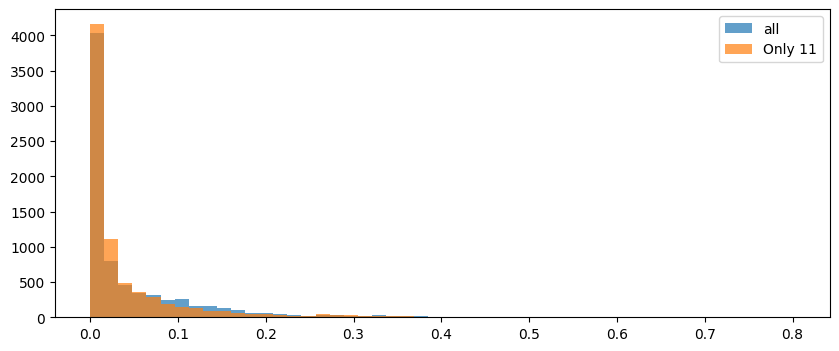

In [29]:
plt.hist(np.abs(res_all),bins=50,
         range=[0,np.max(np.array([np.max(np.abs(res_all)),np.max(np.abs(res_one))]))],
         alpha=0.7)
plt.hist(np.abs(res_one),bins=50,
         range=[0,np.max(np.array([np.max(np.abs(res_all)),np.max(np.abs(res_one))]))],
         alpha=0.7)
plt.legend(['all','Only 11'])

In [73]:
quant_rate_all=QuantileNetwork.quant_rate(y_test_all.to_numpy()[:,10],y_preds_all_11)
quant_rate_one=QuantileNetwork.quant_rate(y_test_one.to_numpy()[:,0],y_preds_one)

print("Quantile rate, model trained for all channels: "+str(quant_rate_all))
print("Quantile rate, model trained for channel 11: "+str(quant_rate_one))

Quantile rate, model trained for all channels: [0.09573811 0.85114268 0.99382335]
Quantile rate, model trained for channel 11: [0.04138357 0.50895615 0.95799876]


In [72]:
np.sum(np.abs(model_one.model.linear[0].weight.data.cpu().numpy()),axis=0)

array([29.636457 , 14.998204 , 12.405648 , 14.352423 , 11.511163 ,
       12.46822  , 12.936542 , 18.347027 , 13.233132 ,  7.7546835,
       70.347435 , 43.546627 ,  2.3557925, 21.987385 ,  2.2772846],
      dtype=float32)

In [69]:
X_labels

['Cloud_B02',
 'Cloud_B03',
 'Cloud_B04',
 'Cloud_B05',
 'Cloud_B06',
 'Cloud_B07',
 'Cloud_B08',
 'Cloud_B09',
 'Cloud_B10',
 'Cloud_B11',
 'Cloud_B12',
 'Cloud_B13',
 'Sat_Zenith_Angle',
 'Sun_Zenith_Angle',
 'Azimuth_Diff_Angle']

## Test plot metrics function

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

/tmp/ipykernel_244695/254083166.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-01 12:31:24.122804: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-01 12:31:24.157672: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 12:31

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)


CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [3]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=pd.concat([data_water, data_ice, data_mixed])
#data_all=pd.concat([data_ice])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

df=data_all.copy()
#data_all=hf.add_MSI_noise(data_all,channel_labels)

##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels_one=['Clear_B12']
y_labels_all=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']

In [4]:
#Load models
model_all,X_test,y_test_all=hf.load_model_and_test_data('pytorch_models/test_estimate_1_v_all_channels/all')
model_one,X_test,y_test_one=hf.load_model_and_test_data('pytorch_models/test_estimate_1_v_all_channels/one')


In [5]:
pred_y_1=model_all.predict(X_test.to_numpy())
#pred_y_1=pred_y_1[:,10,:]

pred_y_2=model_one.predict(X_test.to_numpy())
pred_y_2=pred_y_2[:,0,:]

In [6]:
from functions.plot_metrics import plot_metrics

In [7]:
x_tmp=X_test.reset_index()
x_tmp=x_tmp.drop(columns=["index"])

/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/edgelab/filip/SEEX30_Cloud_Fog/SEEX30_Cloud_Fog/Cloud_rm/functions/plot_metrics.py:172: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax_5[i].errorbar(x=np.linspace(0,len(y_pred_sort_samp[i][:,1]),len(y_pred_sort_samp[i][:,1]))


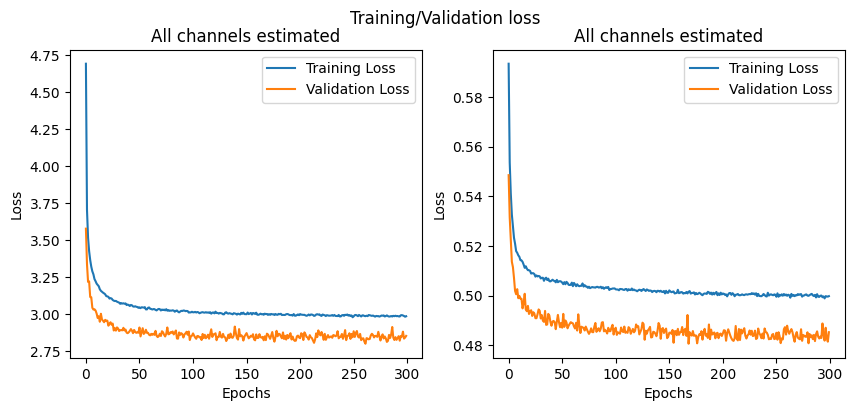

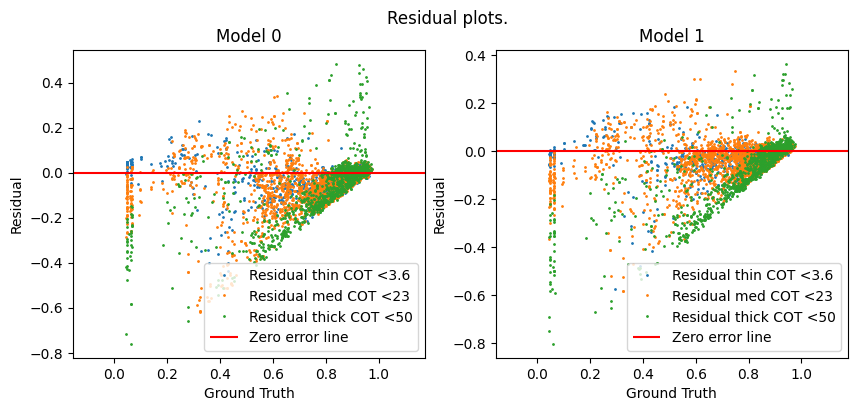

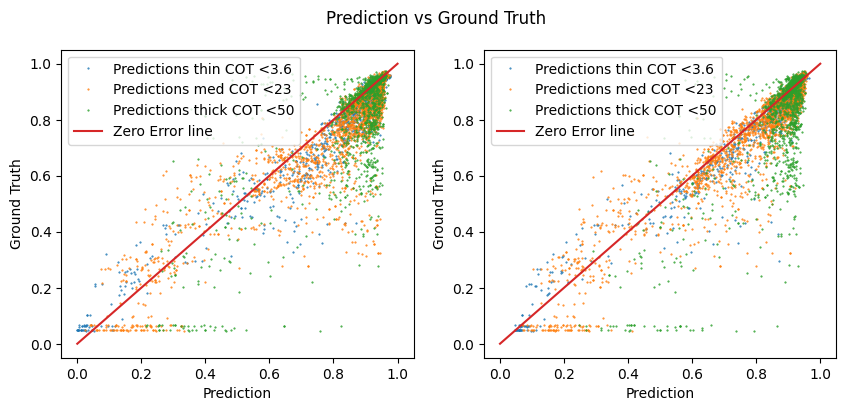

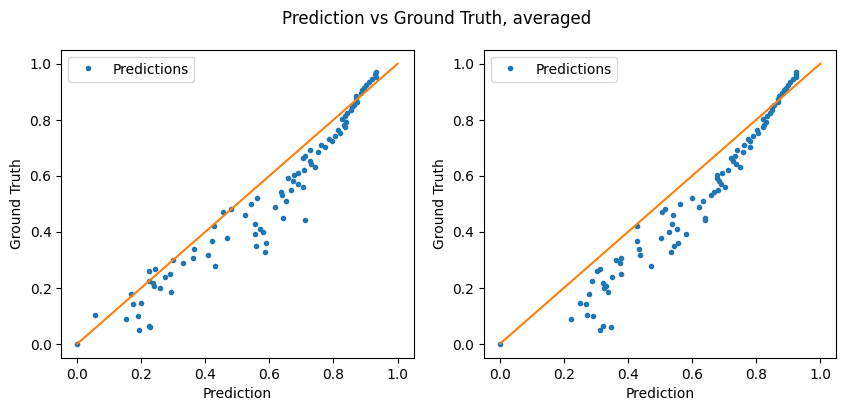

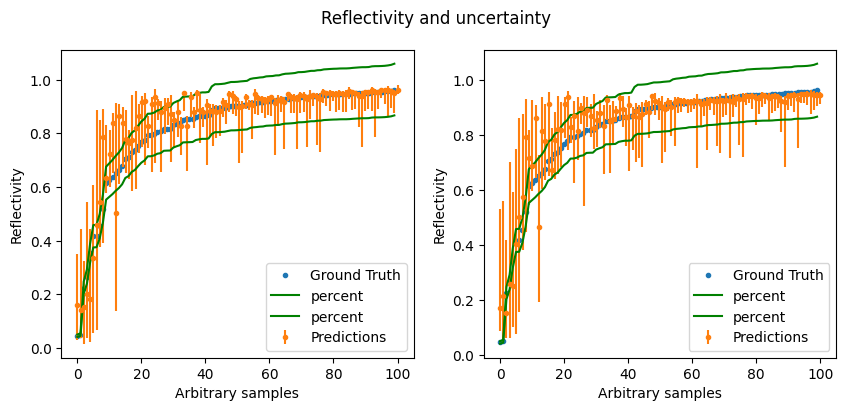

In [8]:
plt.rcParams["figure.figsize"] = [10, 4]
figs,axs,mses,r2s,psnrs,quantrates,quantcrosses = plot_metrics([model_all,model_one],
                                                                [X_test,X_test],
                                                                [y_test_all,y_test_one],
                                                                [pred_y_1,pred_y_2],
                                                                df,
                                                                samples=100)
#plt.close('all')


In [11]:
for i,mse in enumerate(mses):
    print("MSE for model "+str(i)+': '+str(mse))
print(" ")
for i,r2 in enumerate(r2s):
    print("R2 score for model "+str(i)+': '+str(r2))
print(" ")
for i,psnr in enumerate(psnrs):
    print("PSNR for model "+str(i)+': '+str(psnr))
print(" ")
for i,quantrate in enumerate(quantrates):
    print("Quantrate for model "+str(i)+': '+str(quantrate))
print(" ")
for i,quantcross in enumerate(quantcrosses):
    print("Quantile crossing for model "+str(i)+': '+str(quantcross))

MSE for model 0: 0.008888133088423275
MSE for model 1: 0.007084249057615247
 
R2 score for model 0: 0.7566043074949236
R2 score for model 1: 0.8060024880250102
 
PSNR for model 0: 20.40519109118989
PSNR for model 1: 21.39035837031344
 
Quantrate for model 0: [0.08053333 0.7396     0.98453333]
Quantrate for model 1: [0.05853333 0.49066667 0.94293333]
 
Quantile crossing for model 0: 0.0
Quantile crossing for model 1: 0.0
